## 02. 군집 평가 (Cluster Evaluation)
- 대부분의 군집화는 타깃 레이블을 가지고 있지 않음
- 데이터 내에 숨어있는 별도의 그룹을 찾아서 의미를 부여하거나, 동일한 분류 값에 속하더라도 그 안에서 더 세분화된 군집화를 추구하거나, 서로 다른 분류 값의 데이터도 더 넓은 군집화 레벨화 등의 영역을 포함

### 실루엣 분석(silhouette analysis)
- 각 군집 간의 거리가 얼마나 효율적으로 분리되어 있는지(다른 군집과는 떨어져 있고, 동일 군집과는 서로 가깝게 뭉쳐있음)를 나타냄
- 실루엣 계수 (silhouette coefficient)
$$s(i) = \frac{b(i)-a(i)}{max(a(i), b(i))},\ -1 < s(i) < 1 $$
    - s → 1 : 근처 군집과 멀리 떨어져있음
    - s → 0 : 근처 군집과 가까워짐
    - s < 0 : 다른 군집에 데이터 포인트가 할당됨

#### 메서드

```
1. sklearn.metrics.silhouette_samples(X, labels, *, metric='euclidean', **kwds)
```
: 각 데이터 포인트의 실루엣 계수를 계산해 반환

```
2. sklearn.metrics.silhouette_score(X, labels, *, metric='euclidean', sample_size=None, random_state=None, **kwds)
```
: 전체 데이터의 실루엣 계수 값을 평균해 반환 = np.mean(silhouette_sample()), 일반적으로 높을수록 군집화 Good! but 무조건 값이 높다고 해서 군집화가 잘 됐다고 판단하기 어려움

#### 좋은 군집화의 조건
1. 전체 실루엣 계수의 평균값 $\in$ [0,1], 1에 가까울수록 Good!
2. 개별 군집의 평균값의 편차가 크지 않아야 함. 즉, 개별 군집의 실루엣 계수 평균값이 전체 실루엣 계수의 평균값에서 크게 벗어나지 않는 것이 중요!



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 붓꽃 데이터 세트를 이용한 군집 평가

In [3]:
from sklearn.datasets import load_iris
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns = cols)

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0)
kmeans.fit(iris_df)
centers = kmeans.cluster_centers_
# iris_df['cluster'] = kmeans.predict(iris_df)
iris_df['cluster'] = kmeans.labels_

# silhouette_samples
score_samples = silhouette_samples(iris.data, iris_df['cluster'])
print(score_samples.shape)

# silhouette_score
iris_df['sil_coeff'] = score_samples

avg_score = silhouette_score(iris.data, iris_df['cluster'])
print(avg_score)

iris_df.head()

(150,)
0.552819012356409


,sepal_length,sepal_width,petal_length,petal_width,cluster,sil_coeff
0,5.1,3.5,1.4,0.2,1,0.852955
1,4.9,3.0,1.4,0.2,1,0.815495
2,4.7,3.2,1.3,0.2,1,0.829315
3,4.6,3.1,1.5,0.2,1,0.805014
4,5.0,3.6,1.4,0.2,1,0.849302


- 1번 군집의 경우 0.8 이상의 높은 실루엣 계수 값을 가지는데, 이는 다른 군집의 실루엣 계수 값이 평균보다 낮음을 내포

In [4]:
iris_df.groupby('cluster')['sil_coeff'].mean()

cluster
0    0.417320
1    0.798140
2    0.451105
Name: sil_coeff, dtype: float64

### 군집별 평균 실루엣 계수의 시각화를 통한 군집 개수 최적화 방법
- 사이킷런 시각화 문서 [링크](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- 교재 부록 [링크](https://github.com/wikibook/ml-definitive-guide/blob/master/7%EC%9E%A5/7-2_Cluster%20evaluation.ipynb)

#### visualize_silhouette() 
군집 개수를 변화시키면서 K-평균 군집을 수행했을 때 개별 군집별 평균 실루엣 계수 값을 시각화해서 군집의 개수를 정하는데 도움

In [5]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

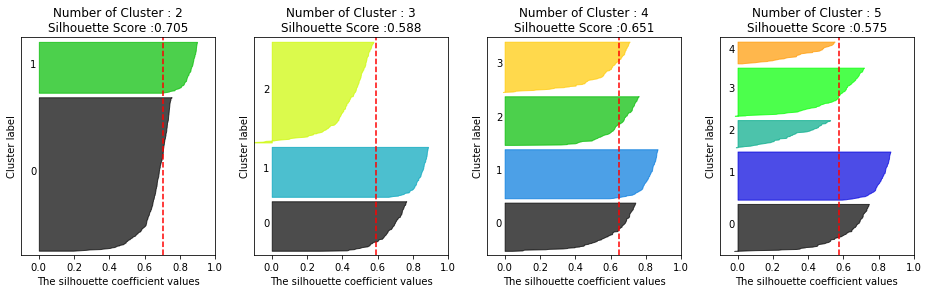

In [6]:
# make_blobs 데이터셋 이용
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1, center_box=(-10, 10), 
                  shuffle=True, random_state=1)

visualize_silhouette([2,3,4,5], X)

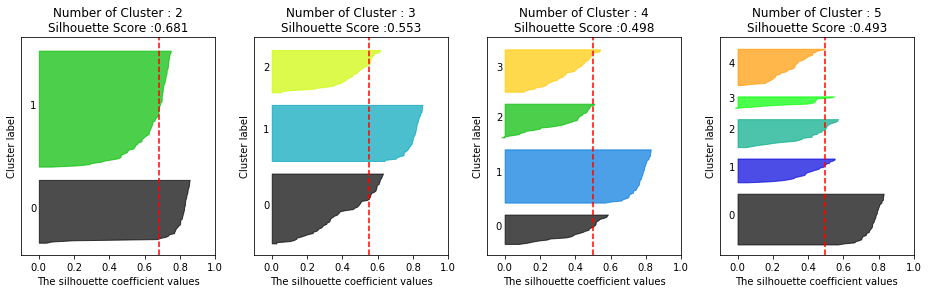

In [7]:
# iris 데이터셋 이용
from sklearn.datasets import load_iris

iris = load_iris()
visualize_silhouette([2,3,4,5], iris.data)

- 붓꽃 데이터를 K-평균으로 군집화할 경우에 군집 개수를 2개로 하는 것이 가장 좋아보임